In [1]:
import numpy as np
from sim.dy import Model
import json
import pandas as pd
import matplotlib.pylab as plt
from mc import *
import pymc as pm

In [2]:
with open('data/test_priors.json', 'r') as f:
    prior = json.load(f)

m = Model(year0=1970)

p0 = prior[0]
p0.update({'beta_ds': 11, 'rr_risk_comorb': 20, 'rr_beta_dr': 1.02, 'p_comorb': 0.3})

In [3]:
%timeit m.simulate(p0)

1.29 s ± 25.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit m.simulate_to_fit(p0)

971 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
#%prun m.simulate(p0)

## Test model fitting

In [5]:
targets = json.load(open('data/targets.json', 'r'))
targets = pd.DataFrame(targets)
targets

,Index,M,L,U
0,Prev,0.004754,0.004127,0.005418
1,ARTI,0.013254,0.010844,0.015663
2,PrDR_CNR,0.041000,0.035000,0.045000
3,PrAsym,0.631150,0.565854,0.697561
4,PrPreCS,0.132902,0.087805,0.180488
5,PrExCS,0.187874,0.136585,0.243902
6,PrSpAsym,0.329022,0.251799,0.410072
7,PrSpPreCS,0.389226,0.222222,0.555556
8,PrSpExCS,0.379036,0.200000,0.566667


In [6]:
src = load_objectives(path_target='data/targets.json')


In [7]:
model = src.build_model()

In [8]:
with model:
    fit = pm.sample_smc(draws=10, chains=1)
    ppost = pm.sample_posterior_predictive(fit)

Initializing SMC sampler...
Sampling 1 chain in 1 job


/opt/conda/envs/pymc-dev/lib/python3.10/site-packages/pymc/smc/sample_smc.py:248: UserWarning: The number of samples is too small to check convergence reliably.
  _compute_convergence_checks(idata, draws, model, trace)


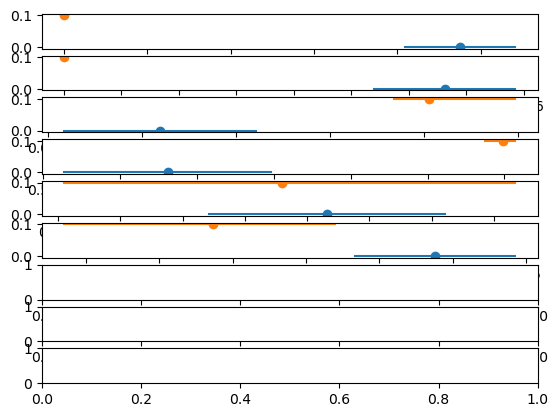

In [9]:
obs, eps = src.Obs, src.Eps

fig, ax = plt.subplots(nrows=9)


m = np.mean(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 1)
l = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.025, 1)
u = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.975, 1)

for i in range(6):
    ax[i].scatter(obs[i], 0)
    ax[i].plot([obs[i] - eps[i], obs[i] + eps[i]], [0, 0] )
    
    ax[i].scatter(m[i], 0.1)
    ax[i].plot([l[i], u[i]], [0.1, 0.1] )
    
    